In [134]:
import pyart
import time
import multidop
import tempfile
from netCDF4 import Dataset
from copy import deepcopy
from scipy import ndimage
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [58]:
cpol_file_path = '/home/rjackson/runtwp1a_cfradial/crsimwrfruntwp1acpolCPOL.a02.20060120.005000.cdf'
berr_file_path = '/home/rjackson/runtwp1a_cfradial/crsimwrfruntwp1acpolBERR.a02.20060120.005000.cdf'
wrf_run_path = '/home/rjackson/satoshi_runs/twp1a/wrfout_d01_2006-01-20_00:00:00'

In [24]:
cpol_radar = pyart.io.read(cpol_file_path)
cpol_radar.fields.keys()
berr_radar = pyart.io.read(berr_file_path)
berr_radar.fields['reflectivity']['data'].fill_value

9.96921e+36

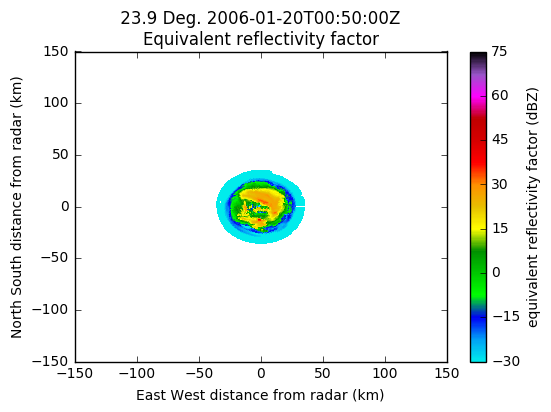

In [203]:
display = pyart.graph.RadarDisplay(cpol_radar)
display.plot_ppi('reflectivity', sweep=12)

In [27]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=4.0, nb=1.5,
               fields=['DT', 'VT'], origin=None, gatefilter=False):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        weighting_function='Barnes',
        gridding_algo='map_gates_to_grid',
        h_factor=h_factor,
        min_radius=min_radius,
        bsp=bsp,
        nb=nb, 
        gatefilters=[gatefilter])
    print(time.time() - bt, 'seconds to grid radar')
    return grid

In [37]:
# Change variable names to DT (reflectivity) and VT (velocity) expected by multidop
# If you needed to dealias or perform other corrections,
# this would be the time to start doing that.
# Both datasets already have aliasing corrections
cp = deepcopy(cpol_radar.fields['reflectivity']['data'])

# Apply texture filter to CPOL data
cpol_radar.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
cp = deepcopy(cpol_radar.fields['corrected_velocity']['data'])
cpol_radar.add_field_like('corrected_velocity', 'VT', cp, replace_existing=True)

cp = deepcopy(berr_radar.fields['reflectivity']['data'])
berr_radar.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
cp = deepcopy(berr_radar.fields['corrected_velocity']['data'])
berr_radar.add_field_like('corrected_velocity', 'VT', cp, replace_existing=True)

# The analysis engine currently expects the "missing_value" attribute
cpol_radar.fields['DT']['_FillValue'] = 1.0 * cpol_radar.fields['DT']['data'].fill_value
berr_radar.fields['DT']['_FillValue'] = 1.0 * berr_radar.fields['DT']['data'].fill_value
cpol_radar.fields['VT']['_FillValue'] = 1.0 * cpol_radar.fields['VT']['data'].fill_value
berr_radar.fields['VT']['_FillValue'] = 1.0 * berr_radar.fields['VT']['data'].fill_value

cpol_radar.fields['DT']['missing_value'] = 1.0 * cpol_radar.fields['DT']['data'].fill_value
berr_radar.fields['DT']['missing_value'] = 1.0 * berr_radar.fields['DT']['data'].fill_value
cpol_radar.fields['VT']['missing_value'] = 1.0 * cpol_radar.fields['VT']['data'].fill_value
berr_radar.fields['VT']['missing_value'] = 1.0 * berr_radar.fields['VT']['data'].fill_value

# Grid the data to a Cartesian grid. The Dual doppler domain does not extend ~60 km 
# from both radars, so no need to store more data than that. 
grid_cpol = grid_radar(cpol_radar, 
                       origin=(cpol_radar.latitude['data'][0], cpol_radar.longitude['data'][0]),
                       xlim=(-60000, 50000), ylim=(-50000, 30000), 
                       fields=['DT', 'VT'], min_radius=750.0, bsp=1.0, nb=1.5,
                       h_factor=2.0,
                       zlim=(500, 20000), grid_shape=(40, 81, 111),
                       gatefilter=None)
grid_Berr = grid_radar(berr_radar, 
                       origin=(cpol_radar.latitude['data'][0], cpol_radar.longitude['data'][0]),
                       fields=['DT', 'VT'],
                       xlim=(-60000, 50000), ylim=(-50000, 30000), 
                       zlim=(500, 20000), min_radius=750.0,  
                       grid_shape=(40, 81, 111),
                       bsp=1.0, nb=1.5, h_factor=2.0,
                       gatefilter=None)

# The analysis engine requires azimuth and elevation to be part of the grid.
# This information is computed from the grid geometry.
grid_cpol = multidop.angles.add_azimuth_as_field(grid_cpol)
grid_Berr = multidop.angles.add_azimuth_as_field(grid_Berr)
grid_cpol = multidop.angles.add_elevation_as_field(grid_cpol)
grid_Berr = multidop.angles.add_elevation_as_field(grid_Berr)

# Save the input grids for later.
pyart.io.write_grid('cpol_Darwin.nc', grid_cpol)
pyart.io.write_grid('berr_Darwin.nc', grid_Berr)

0.8732502460479736 seconds to grid radar
1.0545949935913086 seconds to grid radar


/home/rjackson/anaconda3/lib/python3.5/site-packages/MultiDop-0.2-py3.5.egg/multidop/angles.py:24: RuntimeWarning: invalid value encountered in arccos
  elev = np.arccos((Re**2 + slantrsq - rh**2)/(2 * Re * slantr))


In [40]:
# You don't have to define everything. Most of these keywords are default values.
# If you don't define something the program will provide a default value.
# Check parameters.py for what keyword default values are.
localfile = tempfile.NamedTemporaryFile()
pd = {'dir': './',
      'x': [-60000.0, 1000.0, 111],   # start, step, max = min + (steps-1)
      'y': [-50000.0, 1000.0, 81],
      'z': [500.0, 500.0,  40],
      'grid': [grid_cpol.origin_longitude['data'][0], grid_cpol.origin_latitude['data'][0], 50.0],
      'files': ['berr_Darwin.nc',
                'cpol_Darwin.nc'],
      'radar_names': ['Berrima', 'CPOL'],
      'refl': 'DT',  # Name of reflectivity field. Must be common between radars.
      'vt': 'VT',  # Name of velocity field. Must be common between radars.
      'bgfile': 'sounding_file', # Name of sounding file
      'writeout': localfile.name, # Name of output grid file
      'min_cba': 30.0,  # Minimum beam-crossing angle
      'calc_params': 'cpol_calc.dda', # .dda file for parameters related to minimization routine
      'anel': 1, # 0 = Boussinesq approximation for mass conservation, 1 = anelastic 
      'laplace': 0, # 0 = 1st order derivatives for smoothing, 1 = second
      'read_dataweights': 2, # 0 = calculate data constraint weights/output, 1 = read from file, 2 = weigh all equally
      'max_dist': 10.0, # How much distance analysis and observational grid must match in m
      'cutoff': 0.0, # Deny observations below this level from analysis (m)
      'UT': 3.3, # U of prescribed storm motion vector
      'VT': -3.3, # V of prescribed storm motion vector
      'output_error': 0, # 1 = output verification stats after each iteration
      'weak_height': -1, # Sounding height constraint weakened in regions > 10 dBZ below this height (-1 = disabled)
      'upper_bc': 1, # 1 = w = 0 as upper boundary condition, -1 = ignore
      'itmax_frprmn': [200, 10], # max iterations in frprmn function
      'itmax_dbrent': 200, # max iterations in dbrent function
      'C1b': 0.1,  # Data weighting factor
      'C2b': 1500.0,  # Mass continuity weighting factor
      'C3b': 0.0,  # Vorticity weighting factor
      'C4b': 75.0,  # Horizontal smoothing factor
      'C5b': 0.0,  # Vertical smoothing factor
      'C8b': 0.01,  # Sounding factor
      'vary_weights': 0,
      # Define filter with ONE of the following forms.
      # filter: none
      # filter: filter_frequency Leise nstep
      # filter: filter_frequency low-pass alpha
      'filter': ['60', 'Leise', '2'],
      # Coverage values for various combinations of radars.
      # Each line should provide the type of coverage value, radar count,
      # radar names, and the value, in the following form:
      #
      #   cvg_(""|opt|sub)_(bg|fil): integer radar1 radar2 ... boolean
      #
      # Radars are identified by the OPAWS/OBAN file name with grid data for that
      # radar. This must be just the base name, not the full path.
      #
      # For example:
      #
      #   cvg_opt_bg: SR1 SR2 1
      #
      # says that if SR1 SR2
      # both have data within max_dist meters of the point under consideration,
      # and an optimal beam crossing angle, then the point will receive a coverage
      # value of 1, i.e. point has coverage.
      #
      # "opt" means optimal beam crossing angle.
      # "sub" means suboptimal beam crossing angle.
      # "bg" means background coverage.
      # "fil" means filter coverage.
      # cvg_bg, cvg_fil, and sseq_trip do not require a radar count. (Beam crossing
      # angle is meaningless with one radar, so there is no opt or sub)
      #
      # If this file is being used, coverage values must be provided for all
      # combinations of radars.
      'cvg_opt_bg': [1, 1, 0],
      'cvg_sub_bg': [1, 1, 0],
      'cvg_opt_fil': [0, 0, 0],
      'cvg_sub_fil': [1, 1, 0],
      'cvg_bg': [1, 1, 0],
      'cvg_fil': [0, 0, 0],
      'sseq_trip': [1.0, 1.0, 0.0]
     }
pf = multidop.parameters.ParamFile(pd, 'cpol_test.dda')
pf = multidop.parameters.CalcParamFile(pd, 'cpol_calc.dda')

In [41]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('cpol_test.dda', cmd_path='/home/rjackson/multidop/src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.9.0
./DDA: reading calculation parameters from cpol_calc.dda.
Changing working directory to ./
x: -60000.000000 to 50000.000000 in 110 steps of 1000.000000
y: -50000.000000 to 30000.000000 in 80 steps of 1000.000000
z: 500.000000 to 20000.000000 in 39 steps of 500.000000
z_min=500, cutoff=0
UT=3.3, VT=-3.3
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 30 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART fileberr_Darwin.nc
cpol_Darwin.nc

Radar positions:  (0.706189,-26557.7) (0.706832,-0.0129925)
Computing coverage: 179913 verification points out of 359640 total points.
radar0 190306 obs. radar1 190715 obs. 381021 total obs.
Reading sounding file sounding_file
k        z     USND     VSND |  k        z     USND     VSND
0    500.0     -3.7      2.8 | 20  10500.0     -0.8      1.1
1   1000.0     -4.5      3.6 | 21  11000.0     -1.1      2.4
2   1500.0     -3.2      4.8 | 22  1

In [42]:
# Baseline output is not CF or Py-ART compliant. This function fixes that.
# This is why we wrote the original output to a tempfile that can be safely removed.
# The final grid will have all wind solutions outside the coverage region masked.
fname = 'cf_compliant_grid.nc'
final_grid = multidop.grid_io.make_new_grid([grid_cpol, grid_Berr], 
                                            localfile.name,
                                            use_mask=True)
final_grid.write(fname)
localfile.close()
pyart_grid = pyart.io.read_grid(fname)
print(pyart_grid.fields.keys())

dict_keys(['eastward_wind', 'northward_wind', 'reflectivity', 'upward_air_velocity'])


In [50]:
pyart_grid = pyart.io.read_grid(fname)
print(pyart_grid.fields.keys())

dict_keys(['eastward_wind', 'northward_wind', 'reflectivity', 'upward_air_velocity'])


In [107]:
def get_bca(grid):
    berr_origin = [0,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1472: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1473: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


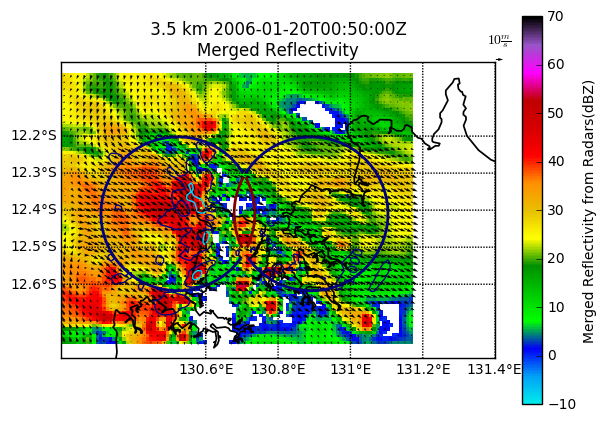

In [109]:
level = 6
fig1 = plt.figure(figsize=(7,5))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
                             min_lon=130.2, max_lon=131.4,
                             auto_range=False,
                             lat_lines=[-12.6, -12.5, -12.4, -12.3, -12.2, -12.0],
                             lon_lines=[130.6, 130.8, 131.0, 131.2, 131.4],
                             resolution='h')
CPOLGridDisplay.plot_grid('reflectivity', level, vmin=-10, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)

lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
v = pyart_grid.fields['northward_wind']['data'][level,::2,::2]
u = pyart_grid.fields['eastward_wind']['data'][level,::2,::2]
w = pyart_grid.fields['upward_air_velocity']['data'][level]
Wcomp = np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0)

q = CPOLGridDisplay.basemap.quiver(lons[::2,::2], lats[::2,::2], 
                                   u, v, 
                                   scale=600,
                                   latlon='True')
qk = plt.quiverkey(q, 1.01, 1.01, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
CS = CPOLGridDisplay.basemap.contour(lons, lats,
                                     w, latlon='True',
                                     levels=[1, 4, 6, 10])
plt.clabel(CS, inline=1, fontsize=10)
bca = get_bca(pyart_grid)

CSa = CPOLGridDisplay.basemap.contour(lons, lats,
                                      bca, latlon='True',
                                      levels=[math.pi/6, 5*math.pi/6],
                                      linewidths=2)

/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1472: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1473: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-50, 50)

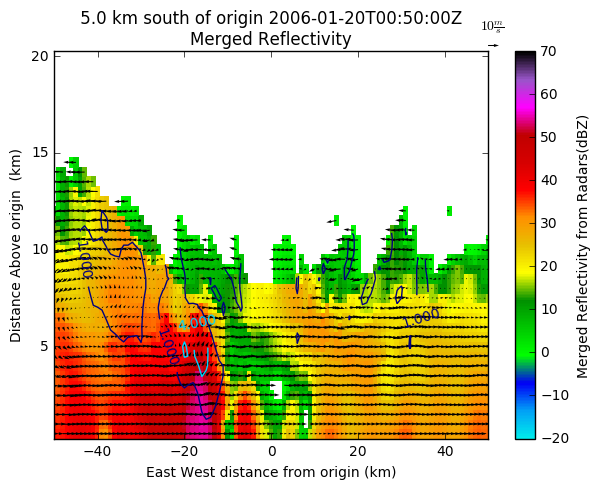

In [111]:
level = 45
fig1 = plt.figure(figsize=(7,5))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
CPOLGridDisplay.plot_latitudinal_level('reflectivity', level,
                                       cmap=pyart.graph.cm.NWSRef,
                                       vmin=-20, vmax=70)                           

X,Y = np.meshgrid(pyart_grid.x['data']/1e3, pyart_grid.z['data']/1e3)
v = pyart_grid.fields['upward_air_velocity']['data'][:,level,:]
u = pyart_grid.fields['eastward_wind']['data'][:,level,:]
q = plt.quiver(X, Y, u, v, scale=400)
qk = plt.quiverkey(q, 1.01, 1.015, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
CS = plt.contour(X,Y, v, levels=[1,4,6,10])
plt.clabel(CS, inline=1, fontsize=10)
plt.xlim([-50, 50])

In [79]:
wrf_cdf = Dataset(wrf_run_path, mode='r')
Z_wrf = wrf_cdf.variables['REFL_10CM'][:,:,:,:]
Lat_wrf = wrf_cdf.variables['XLAT'][:,:,:]
Lon_wrf = wrf_cdf.variables['XLONG'][:,:,:]
W_wrf = wrf_cdf.variables['W'][:]
V_wrf = wrf_cdf.variables['V'][:]
U_wrf = wrf_cdf.variables['U'][:]
PH_wrf = wrf_cdf.variables['PH'][:]
PHB_wrf = wrf_cdf.variables['PHB'][:]
ETA_wrf = wrf_cdf.variables['ZNW'][:]
array_shape = PH_wrf.shape
alt_wrf = (PH_wrf+PHB_wrf)/9.81

(18, 97, 174, 174)


/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1472: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1473: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


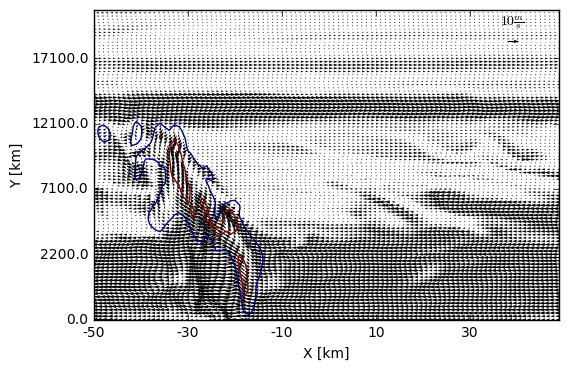

In [130]:
print(W_wrf.shape)
cpol_x = 56
cpol_y = 100
w = W_wrf[4,:-1,cpol_y-5,cpol_x-50:cpol_x+50]
v = V_wrf[4,:,cpol_y-5,cpol_x-50:cpol_x+50]
u = U_wrf[4,:,cpol_y-5,cpol_x-50:cpol_x+50]
z = Z_wrf[4,:,cpol_y-5,cpol_x-50:cpol_x+50]
alt = alt_wrf[4,:,87-40:87+40,87]
lat = Lat_wrf[:,87-40:87+40,87]
x, y, z = np.meshgrid(np.arange(-40, 40, 1), np.arange(-40, 40, 1), np.arange(0,97,1))
q= plt.quiver(v, w, scale=400)
qk = plt.quiverkey(q, 0.9, 0.9, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
plt.contour(w, levels=[1,4])
plt.xticks(range(0,100,20), [str(x-50) for x in np.arange(0,100,20)])
plt.yticks(range(0,100,20), [str(round(np.mean(alt[x]),-2)) for x in np.arange(0,100,20)])
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
#plt.colorbar()

In [196]:
num_levels = 40
times = [0]
ws = np.ma.zeros((len(times), num_levels, 81, 111))
ws_all = np.ma.zeros((len(times), num_levels, 81, 111))
minzs = np.ma.zeros((len(times), num_levels, 81, 111))
maxzs = np.ma.zeros((len(times), num_levels, 81, 111))
Zs = np.ma.zeros((len(times), num_levels, 81, 111))
max_w_individual = []
level_individual = []
label_individual = []
count_individual = []
count = 0
n = 0

## Get all continous regions of W > 1 m s-1 in 3D w array

bca = get_bca(pyart_grid)
w = pyart_grid.fields['upward_air_velocity']['data']
Z = pyart_grid.fields['reflectivity']['data']
w_all = deepcopy(w)
for levels in range(0,num_levels-1):
    w[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                               bca > 5*math.pi/6), 
                                                 w[levels] < 1), w[levels])
    Z[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                               bca > 5*math.pi/6), 
                                                 w[levels] < 1), Z[levels])
    w_all[levels] = np.ma.masked_where(np.logical_or(bca < math.pi/6,
                                                     bca > 5*math.pi/6), 
                                                     w_all[levels])

grid_x = pyart_grid.point_x['data']
grid_y = pyart_grid.point_y['data']
grid_z = pyart_grid.point_z['data']

# Set mask to exclude data outside of updrafts
w_temp = deepcopy(w)
w_temp[~w_temp.mask] = 1
w_temp[w_temp.mask] = 0
w_temp.mask = False

six_connected_structure = [[[0,0,0],
                            [0,1,0],
                            [0,0,0]],
                           [[0,1,0],
                            [1,1,1],
                            [0,1,0]],
                           [[0,0,0],
                            [0,1,0],
                            [0,0,0]]]

updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                    structure=six_connected_structure)

# Get statistics in continous regions
index=np.arange(0, num_updrafts + 1)
max_z = ndimage.measurements.maximum(grid_z, 
                                     labels=updrafts, 
                                     index=index)
min_z = ndimage.measurements.minimum(grid_z, 
                                     labels=updrafts,
                                     index=index)

deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 1000))
depth = max_z-min_z

max_z_olevel = np.ma.zeros((81,111))
min_z_olevel = np.ma.zeros((81,111))
max_z_level = np.ma.zeros((num_levels, 81,111))
min_z_level = np.ma.zeros((num_levels, 81,111))

# Find deep convective cores and get max updraft speeds
for levels in range(0,num_levels-1):
    label_level = updrafts[levels]
    masked_array = np.ma.zeros(updrafts.shape)
    masked_array.mask = True
    w_temp = w[levels]

    for labels in range(1, len(max_z)-1):
        indicies = np.ma.where(label_level == labels)                                
        max_z_olevel[indicies] = max_z[labels]
        min_z_olevel[indicies] = min_z[labels]

        if(len(indicies[0]) > 0  
           and max_z[labels]-min_z[labels] >= 5000
           ):
            max_w_individual.append(max(w_temp[indicies]))
            level_individual.append(levels)
            n = n + 1
            label_individual.append(labels)
            count_individual.append(count)

    max_z_level[levels] = max_z_olevel
    min_z_level[levels] = min_z_olevel

ws[count] = w
ws_all[count] = w_all
minzs[count] = min_z_level
maxzs[count] = max_z_level 
Zs[count] = Z
count = count + 1


max_w_individual = np.array(max_w_individual)
level_individual = np.array(level_individual)
label_individual = np.array(label_individual)
count_individual = np.array(count_individual)
updraft_nos = np.zeros(len(count_individual))
updraft_count = 0
for counts in range(0, max(count_individual)):
    labels = label_individual[count_individual == counts]
    for i in np.unique(labels):
        updraft_nos[np.logical_and(count_individual == counts,
                                   label_individual == i)] = updraft_count
        updraft_count = updraft_count + 1
    
print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

# Calculate PDF
mean_w = np.ma.zeros(num_levels)
median_w = np.ma.zeros(num_levels)
max_w = np.ma.zeros(num_levels)
mean_z = np.ma.zeros(num_levels)
median_z = np.ma.zeros(num_levels)
max_z = np.ma.zeros(num_levels)
ninety_w = np.ma.zeros(num_levels)
ninety_five_w = np.ma.zeros(num_levels)
ninety_nine_w = np.ma.zeros(num_levels)
total_counts = np.ma.zeros(num_levels)

bins = np.arange(0,40,1)
bins_z = np.arange(0,60,1)
h_bins = np.arange(0, 20000, 500)
w_hist = np.ma.zeros((num_levels, len(bins)-1))
w_hist_all = np.ma.zeros((num_levels, len(bins)-1))
dims = ws.shape

# Make p.d.f.s 
print(num_levels)
updraft_no = 2
for levels in range(0,num_levels):
    w_level = ws[:,levels,:,:]
    z_level = Zs[:,levels,:,:]
    minz_level = minzs[:,levels,:,:]
    maxz_level = maxzs[:,levels,:,:]
    
    ws_in_core = w_level[~w_level.mask]
    minzs_in_core = minz_level[~w_level.mask]
    maxzs_in_core = maxz_level[~w_level.mask]
    max_w_level = ndimage.measurements.maximum(w[levels],
                                               labels=updrafts[levels],
                                               index=index)
    
    mean_w[levels] = np.ma.mean(max_w_individual[level_individual == levels])
    median_w[levels] = np.ma.median(max_w_individual[level_individual == levels])
    

    counts, b = np.histogram(ws_in_core, bins=bins)    
    w_hist[levels] = counts

    counts, b = np.histogram(w_level, bins=bins)
    w_hist_all[levels] = counts 
    
    total_counts[levels] = len(max_w_individual[level_individual == levels])
    if(len(ws_in_core) > 0):
        ninety_w[levels] = np.percentile(max_w_individual[level_individual == levels], 90)
        ninety_five_w[levels] = np.percentile(max_w_individual[level_individual == levels], 95)
        ninety_nine_w[levels] = np.percentile(max_w_individual[level_individual == levels], 99)
    else:
        ninety_five_w[levels] = float('nan')
        ninety_nine_w[levels] = float('nan')
        ninety_w[levels] = float('nan')

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: R

1 DCCs found
40


/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:5144: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [197]:
height = np.zeros(array_shape[1:])
num_levels = array_shape[1]
mean_w_wrf = np.ma.zeros((num_levels))
median_w_wrf = np.ma.zeros((num_levels))
max_w_wrf = np.ma.zeros((num_levels))
height_level = np.ma.zeros((num_levels))
ninety_w_wrf = np.ma.zeros((num_levels))
ninety_five_w_wrf = np.ma.zeros((num_levels))
ninety_nine_w_wrf = np.ma.zeros((num_levels))
w_hist_wrf = np.ma.zeros((num_levels, 
                          len(bins)-1))
w_hist_all = np.ma.zeros((num_levels, 
                          len(bins)-1))
total_counts_wrf = np.ma.zeros((array_shape[1]))


max_w_individual = []
level_individual = []
label_individual = []
count_individual = []
height_individual = []
j = 4
i = 4
## Get all continous regions of W > 1 m s-1 in 3D w array

w = np.ma.array(W_wrf[j])
z = np.ma.array(Z_wrf[j])
alts = alt_wrf[j]

w_all = deepcopy(w)

for levels in range(0,array_shape[1]):
    if(levels == array_shape[1]-1):
        z_level = levels-1
    else:
        z_level = levels
    w[levels] = np.ma.masked_where(np.logical_or(w[levels] < 1, z[z_level] < 0), w[levels])
    w_all[levels] = W_wrf[j][i,levels]
height = alts

grid_z = height

# Set mask to exclude data outside of updrafts
w_temp = deepcopy(w)
w_temp[~w_temp.mask] = 1
w_temp[w_temp.mask] = 0
w_temp.mask = False

six_connected_structure = [[[0,0,0],
                            [0,1,0],
                            [0,0,0]],
                           [[0,1,0],
                            [1,1,1],
                            [0,1,0]],
                           [[0,0,0],
                            [0,1,0],
                            [0,0,0]]]

updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                    structure=six_connected_structure)

# Get statistics in continous regions
index=np.arange(0, num_updrafts + 1)

max_z = ndimage.measurements.maximum(grid_z, 
                                     labels=updrafts, 
                                     index=index)
min_z = ndimage.measurements.minimum(grid_z, 
                                     labels=updrafts,
                                     index=index)
deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 1000))

depth = max_z-min_z
max_z_olevel = np.ma.zeros((array_shape[2],
                            array_shape[3]))
min_z_olevel = np.ma.zeros((array_shape[2],
                            array_shape[3]))
max_z_level = np.ma.zeros((array_shape[1],
                           array_shape[2],
                           array_shape[3]))
min_z_level = np.ma.zeros((array_shape[1],
                           array_shape[2],
                           array_shape[3]))

# Find deep convective cores and get max updraft speeds
for levels in range(0,array_shape[1]):
    label_level = updrafts[levels]
    masked_array = np.ma.zeros(updrafts.shape)
    masked_array.mask = True
    w_temp = w[levels]
    height_temp = height[levels]
    for labels in range(1, len(max_z)-1):
        indicies = np.ma.where(label_level == labels)                                
        max_z_olevel[indicies] = max_z[labels]
        min_z_olevel[indicies] = min_z[labels]

        if(len(indicies[0]) > 0  
           and max_z[labels]-min_z[labels] >= 5000):
            max_w_individual.append(max(w_temp[indicies]))
            level_individual.append(levels)
            n = n + 1
            label_individual.append(labels)
            count_individual.append(count)
            height_individual.append(np.mean(height_temp[indicies]))

    max_z_level[levels] = max_z_olevel
    min_z_level[levels] = min_z_olevel

count = count + 1

max_w_individual = np.array(max_w_individual)
level_individual = np.array(level_individual)
label_individual = np.array(label_individual)
count_individual = np.array(count_individual)
height_individual = np.array(height_individual)
updraft_nos = np.zeros(len(count_individual))
updraft_count = 0

for counts in range(0, max(count_individual)):
    labels = label_individual[count_individual == counts]
    for i in np.unique(labels):
        updraft_nos[np.logical_and(count_individual == counts,
                                   label_individual == i)] = updraft_count
        updraft_count = updraft_count + 1

print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

# Calculate PDF   
bins = np.arange(0,40,1)
bins_z = np.arange(0,60,1)
h_bins = np.arange(0, 20000, 500) 
dims = ws.shape

# Make p.d.f.s 
updraft_no = 2
for levels in range(0,array_shape[1]):
    mean_w_wrf[levels] = np.ma.mean(max_w_individual[level_individual == levels])
    median_w_wrf[levels] = np.ma.median(max_w_individual[level_individual == levels])
    height_level[levels] = np.nanmean(height_individual[level_individual == levels])
    counts, b = np.histogram(ws_in_core, bins=bins)    
    w_hist_wrf[levels] = counts

    counts, b = np.histogram(w_level, bins=bins)
    w_hist_all[levels] = counts 

    total_counts_wrf[levels] = len(max_w_individual[level_individual == levels])
    if(len(np.where(level_individual == levels)) > 0):
        ninety_w_wrf[levels] = np.nanpercentile(max_w_individual[level_individual == levels], 90)
        ninety_five_w_wrf[levels] = np.nanpercentile(max_w_individual[level_individual == levels], 95)
        ninety_nine_w_wrf[levels] = np.nanpercentile(max_w_individual[level_individual == levels], 99)
    else:
        ninety_five_w_wrf[levels] = float('nan')
        ninety_nine_w_wrf[levels] = float('nan')
        ninety_w_wrf[levels] = float('nan')

1 DCCs found


/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:5144: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:139: RuntimeWarning: Mean of empty slice
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


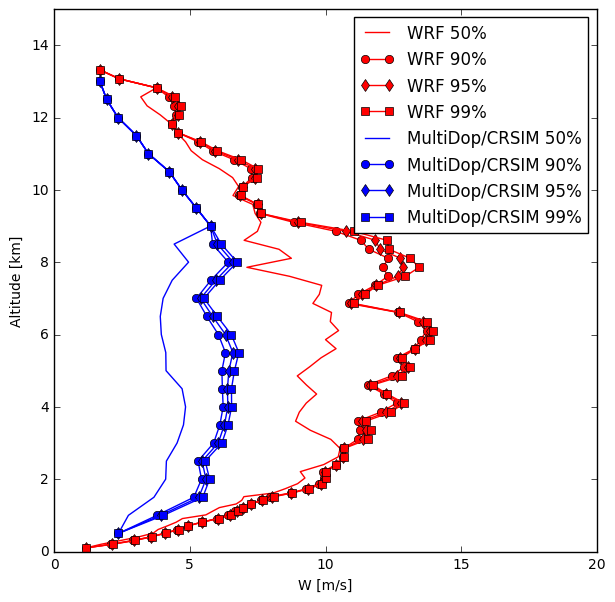

In [195]:
plt.figure(figsize=(7,7))
plt.plot(median_w_wrf, height_level/1e3, color='r')
plt.plot(ninety_w_wrf, height_level/1e3, color='r', marker='o')
plt.plot(ninety_five_w_wrf, height_level/1e3, color='r', marker='d')
plt.plot(ninety_nine_w_wrf, height_level/1e3, color='r', marker='s')

plt.plot(median_w, np.arange(0,20,0.5), color='b')
plt.plot(ninety_w, np.arange(0,20,0.5), color='b', marker='o')
plt.plot(ninety_five_w, np.arange(0,20,0.5), color='b', marker='d')
plt.plot(ninety_nine_w, np.arange(0,20,0.5), color='b', marker='s')
legend(['WRF 50%', 'WRF 90%', 'WRF 95%', 'WRF 99%', 'MultiDop/CRSIM 50%', 'MultiDop/CRSIM 90%', 'MultiDop/CRSIM 95%', 'MultiDop/CRSIM 99%'], loc='best')
plt.xlim([0,20])
plt.ylim([0,15])
plt.xlabel('W [m/s]')
plt.ylabel('Altitude [km]')